In [678]:
import os
os.path.abspath(os.getcwd())

'/zfsauton2/home/cgmorale/sketchesGAN/pix2pix'

In [679]:
from pathlib import Path
from natsort import natsorted
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import tensorflow as tf
import time
import datetime
from IPython import display
import numpy as np
import albumentations.augmentations.functional as F


pathStringImages = '/home/scratch/cgmorale/task_segmentation labeling-2021_06_30_20_17_00-segmentation mask 1.1/JPEGImages/'
pathStringMasks = '/home/scratch/cgmorale/task_segmentation labeling-2021_06_30_20_17_00-segmentation mask 1.1/SegmentationClass/'

pathStringImagesList = []
pathStringMasksList = []
pMask = Path(pathStringMasks)
pImages = Path(pathStringImages)

In [680]:
for i in pMask.iterdir():
    pathStringMasksList.append(i)

In [681]:
for j in pImages.iterdir():
    pathStringImagesList.append(j)

In [682]:
sortedMasks = natsorted(pathStringMasksList)
sortedImages = natsorted(pathStringImagesList)
sortedImages = sortedImages[0:265]

In [683]:
def plotMultipleImages(images):    
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        nda = sitk.GetArrayFromImage(images[i])
        fig.add_subplot(rows, columns, i)
        plt.imshow(nda[:,:],cmap='gray')
    plt.show()

In [684]:
trainingImagesSet = []
trainingMasksSet = []
testingImages = []
testingMasks= []

trainingI = sortedImages[0:200]
trainingM = sortedMasks[0:200]

testingI = sortedImages[201:265]
testingM = sortedMasks[201:265]


for i in range(len(trainingI)):
    trainingImages.append(sitk.ReadImage(str(trainingI[i])))
    trainingMasks.append(sitk.ReadImage(str(trainingM[i])))
    
for j in range(len(testingI)):
    testingImages.append(sitk.ReadImage(str(testingI[j])))
    testingMasks.append(sitk.ReadImage(str(testingM[j])))

    

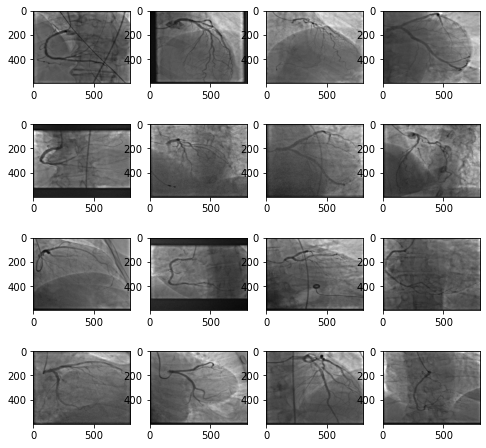

In [685]:
plotMultipleImages(trainingImages)

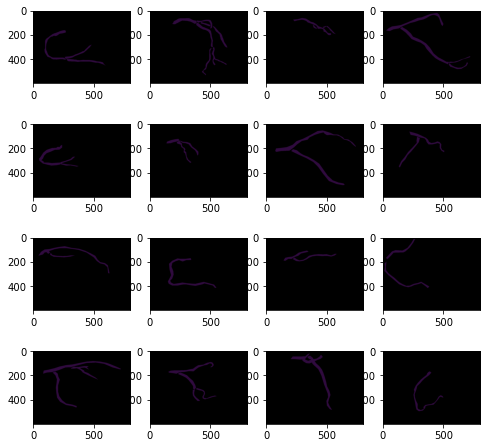

In [686]:
plotMultipleImages(trainingMasks)

In [687]:
def load(imagePath):
    sample_image = tf.io.read_file(str(imagePath))
    sample_image = tf.io.decode_jpeg(sample_image)
    return sample_image

In [688]:
inp = load(sortedImages[0])
sample_mask = load(sortedMasks[0])
sample_image = load(sortedImages[0])

In [689]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [690]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [691]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [692]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [693]:
input_image, real_image = resize(sample_mask, sample_image, 256, 256)

In [694]:
def load_image_train(image_file, real_image):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [695]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [696]:
def get_training_augmentation():
    train_transform = [
        albu.ColorJitter(brightness=0.2, contrast=0.8, saturation=0.7, hue=0.2, always_apply=False, p=0.8),
        albu.RandomRotate90(p=0.3),
        albu.Flip(p=0.3),
        albu.Transpose(p=0.3),
#         albu.OneOf(
#         [
#             albu.OpticalDistortion(p=0.5),
#             albu.IAAPiecewiseAffine(p=0.5)
#         ], p = 0.2),
        albu.RandomContrast(p = 0.4),
#         albu.RandomGamma(p=0.2),
        albu.RandomBrightness(p=0.4),
#         albu.OneOf(
#             [albu.ElasticTransform(alpha = 120,
#                     sigma = 120 * 0.05,
#                     alpha_affine = 120 * 0.03), albu.GridDistortion()],p = 0.5),
        
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=IMG_HEIGHT, min_width=IMG_WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.1,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.1,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [697]:
class Dataset(BaseDataset):
    """
    Args:
        images (SimpleITK Images): dataset images 
        masks (SimpleITK Images): ground truth masks for the corresponding images 
    """
    
    def __init__(self, images, masks,preprocessing=None, augmentation = None):
        #self.ids = os.listdir('/zfsauton/project/upmc_echo/CAMUS/training/')
        self.ids = images
        self.images_fps = images
        self.masks_fps = masks
        self.preprocessing = preprocessing
        self.augmentation = augmentation
    def __getitem__(self, i):
        
        # read data
        imgArray = sitk.GetArrayFromImage(self.images_fps[i])
        # this will give an image of shape [1 x W x H]
        # we need to change it into a size of [W x H x 3] for this model
        img3 = np.zeros([imgArray.shape[0],imgArray.shape[1],3])
        img3[:,:,0] = imgArray[:,:]
        img3[:,:,1] = imgArray[:,:]
        img3[:,:,2] = imgArray[:,:]
        img3 = img3.astype(np.uint8)
        resized_image = albu.resize(img3, height=256, width=256)
        
        maskArray = sitk.GetArrayFromImage(self.masks_fps[i])
        #maskimg = np.zeros([maskArray.shape[0], maskArray.shape[1],1])
        #maskimg[:,:,0] = maskArray[:,:]
        resized_mask = albu.resize(maskArray, height=256, width = 256)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=resized_image, mask=resized_mask)
            resized_image, resized_mask= sample['image'], sample['mask']
            
        #apply augmentation pipeline
        if self.augmentation:
            sample = self.augmentation(image = resized_image, mask = resized_mask)
            resized_image, resized_mask = sample['image'], sample['mask']
        

        return resized_image, resized_mask
        
    def __len__(self):
        return len(self.ids)

In [698]:
augmented_dataset = Dataset(
    trainingImages, 
    trainingMasks, 
    augmentation=get_training_augmentation()
)

testing_dataset= Dataset(testingImages,testingMasks)

/zfsauton2/home/cgmorale/miniconda3/envs/sketchyGAN/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1725: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/zfsauton2/home/cgmorale/miniconda3/envs/sketchyGAN/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [699]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

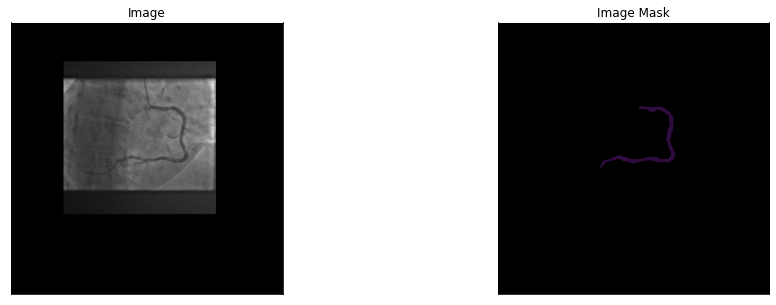

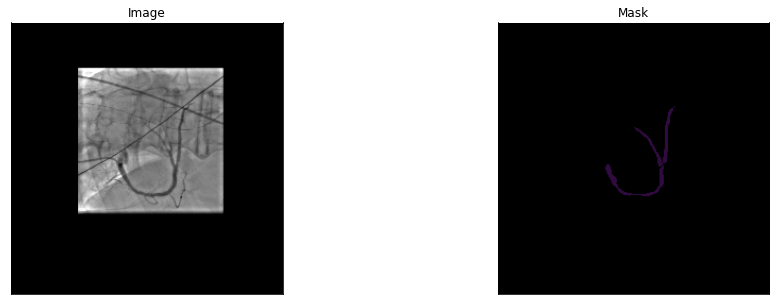

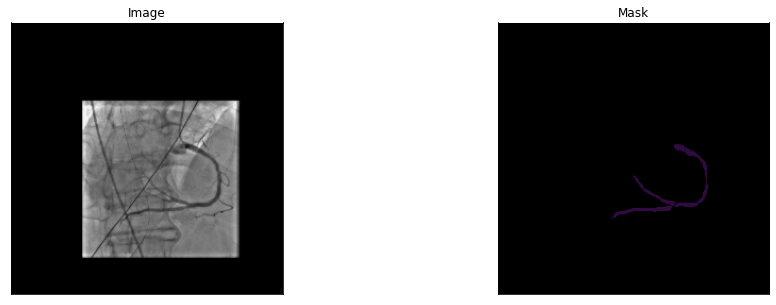

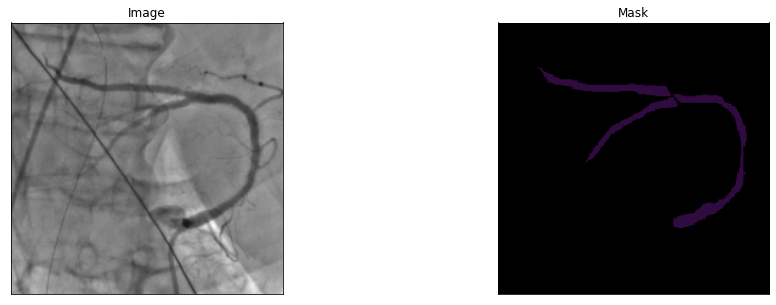

In [700]:
image, mask = augmented_dataset[10] # get some sample
visualize(
    image=image, 
    image_mask=mask.squeeze()
)
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask)

In [701]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [702]:
down_model = downsample(3, 4)
#down_result = down_model(tf.expand_dims(inp, 0))
#print (down_result.shape)

In [703]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [704]:
up_model = upsample(3, 4)

In [705]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

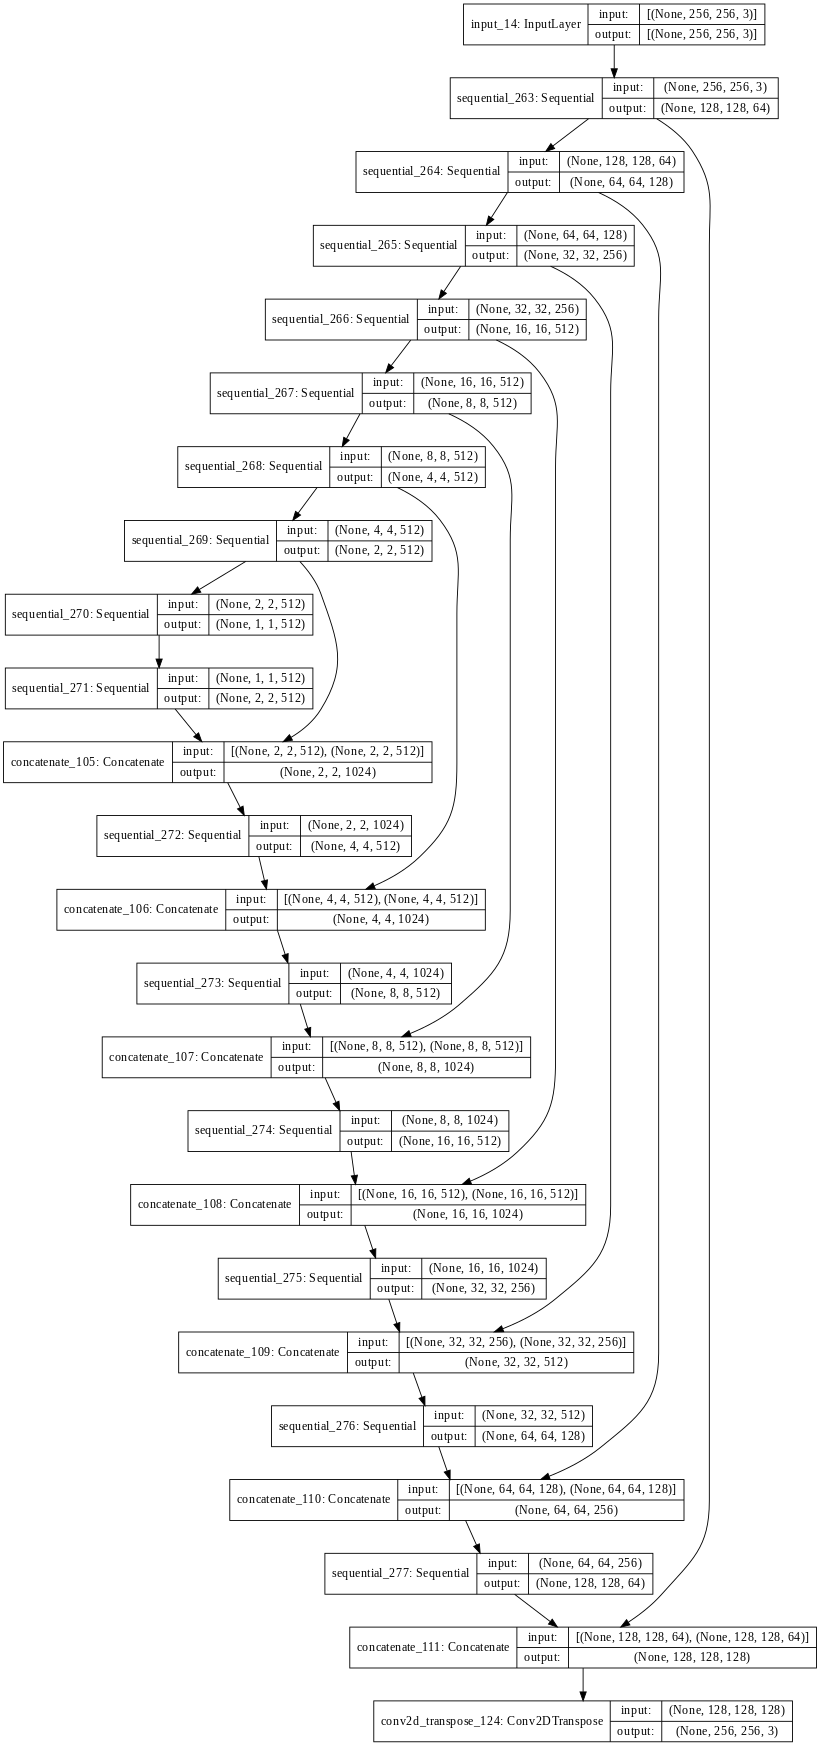

In [706]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


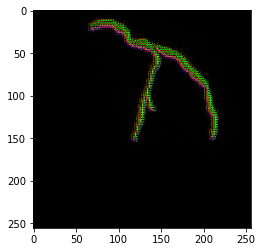

In [707]:
gen_output = generator(input_image[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [708]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  target = tf.image.convert_image_dtype(target, dtype=tf.float32)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [709]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

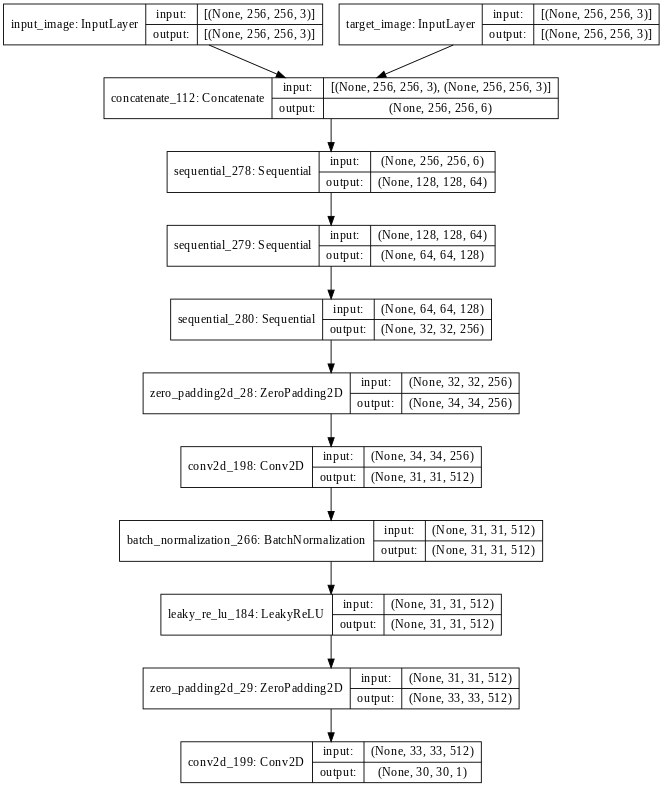

In [710]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

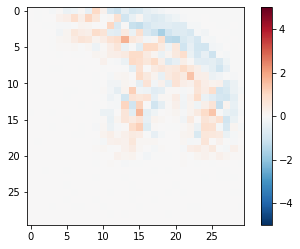

In [711]:
disc_out = discriminator([input_image[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar()

In [712]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [713]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [714]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [715]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [716]:
EPOCHS = 150
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



In [717]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image[tf.newaxis, ...], training=True)

    disc_real_output = discriminator([input_image[tf.newaxis, ...], target[tf.newaxis, ...]], training=True)
    
    disc_generated_output = discriminator([input_image[tf.newaxis, ...], gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [718]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    #example_input, example_target = test_ds[2]
    #generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Training step
    n = 0
    for i in range(len(train_ds)):
        input_image, target = train_ds[i]
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
        input_image, real_image = resize(target, input_image, 256, 256)
        train_step(real_image, input_image, epoch)
        print()

    # Saving (checkpointing) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>


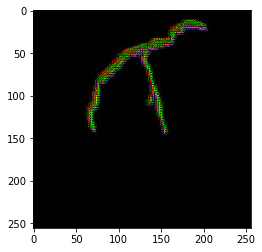

In [719]:
input_image, target = augmented_dataset[0]
input_image, real_image = resize(target, input_image, 256, 256)
gen_output = generator(input_image[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
train_step(real_image,input_image,1)

In [720]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2225239), started 8:16:24 ago. (Use '!kill 2225239' to kill it.)

In [ ]:
fit(augmented_dataset, EPOCHS, testing_dataset)

Epoch:  2
.<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

In [ ]:
tensorboard dev upload --logdir {log_dir}

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)